<a href="https://colab.research.google.com/github/pgarg7/ATMS-597-SP-2020/blob/master/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background

Imports and Installs

In [44]:
!pip install netcdf4
!pip install pydap
!pip install wget

%pylab inline 
import xarray as xr
import wget
import glob
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Mount Drive

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Functions

In [0]:
# Create a function to find months JJA
def is_jja(month):
    return (month >= 6) & (month <= 8)

## Part 1:
Aggregate daily rainfall data from the Global Precipitaiton Climatology Project 1 degree daily precipitation data over the period 1996 - 2019 into a single file from daily files, available here: [https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/].

In [0]:
url = 'https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'
ext = 'nc'

def get_url_paths(url, ext='', params={}):
    response = requests.get(url, params=params)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status()
    soup = BeautifulSoup(response_text, 'html.parser')
    parent = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    return parent

In [0]:
# Loop through all years and grab all of the datasets
years = np.arange(1996,2020)
datasets = []
for i in years:
  result = get_url_paths(url+'{i}/'.format(i=i),ext)
  print('working on {i} '.format(i=i))
  for j in range(len(result)):
    wget.download(result[j])
  files = glob.glob('gpcp*.nc')
  f = xr.open_mfdataset(files,concat_dim='time')
  var = xr.DataArray(f.precip.values,dims=['time','lat','lon'],
                    coords={'time':f.time.values,
                            'lat':f.latitude.values,
                            'lon':f.longitude.values})
  datasets.append(var)
  !rm gpcp*.nc
    #break

In [0]:
# Concatenate the datasets along time dimension
combined = xr.concat(datasets,dim='time')

# Convert to xarray dataset
combined_data = combined.to_dataset(name='precip')

# Convert to netCDF and save
combined_data.to_netcdf('/content/drive/My Drive/ATMS597_Project3_GOCO/GPCP_aggregate.nc',format='NETCDF4')


## Part 2:
Determine the 95% values of daily precipitation during a selected particular 3-month period (given in the table below by group) over the grid box closest to the city you are examining. Plot a cumulative distribution function of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [0]:
# Open the combined dataset
combined_data = xr.open_dataset('/content/drive/My Drive/Colab Notebooks/ATMS597/GPCP_aggregate.nc')

In [0]:
# Slice data for June, July, and August only
jja_data = combined_data.sel(time=is_jja(combined_data['time.month']))

In [80]:
# Find data point: Shanghai, China lat, lon 31.2304° N, 121.4737° E
slat = 31.2304
slon = 121.4737

shanghai_jja = jja_data.sel(lon=slice(slon-.5,slon+.5),lat=slice(slat-.5,slat+.5))
shanghai_jja

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, time: 2117)
Coordinates:
  * lat      (lat) float32 31.0
  * lon      (lon) float32 121.0
  * time     (time) datetime64[ns] 1997-06-30 1997-08-04 ... 2019-07-29
Data variables:
    precip   (time, lat, lon) float32 ...

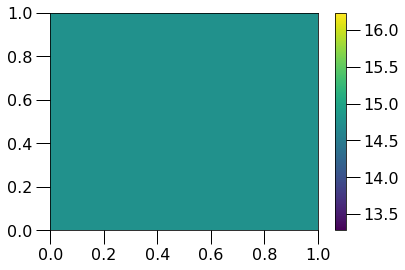

In [81]:
# Plot the Shanghai Precip values
plt.pcolormesh(shanghai_jja.precip.values[0,:,:])
plt.colorbar()
plt.show()

In [0]:
# Find valid values (remove obvious incorrect values)
valid_ind = np.where((shanghai_jja.precip.values>=0.)&(shanghai_jja.precip.values<=1000.))

In [0]:
# Extract valid values
precip_shanghai = shanghai_jja.precip.values[valid_ind]

In [0]:
# Calculate 95 percentile
perc_95 = np.percentile(precip_shanghai,95)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


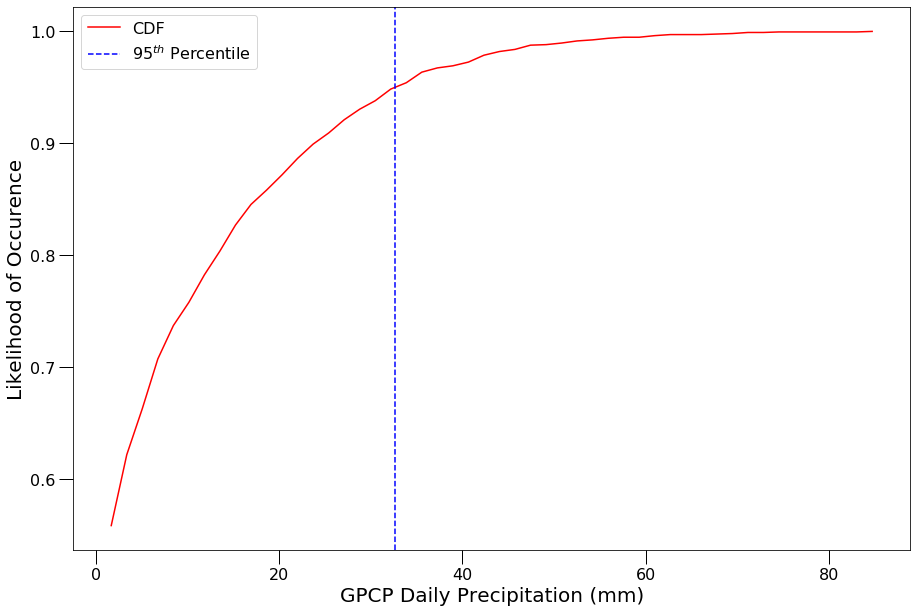

In [85]:
# Plot

# Plotting parameters
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

# Plotting
counts, bin_edges = np.histogram (precip_shanghai, bins=50, normed=True)
cdf = np.cumsum (counts)
plt.figure(figsize=(15,10))
plt.plot (bin_edges[1:], cdf/cdf[-1],'r',label='CDF')
plt.axvline(perc_95,c='b',ls='--',label='$95^{th}$ Percentile')
plt.xlabel('GPCP Daily Precipitation (mm)',fontsize=20)
plt.ylabel('Likelihood of Occurence',fontsize=20)
plt.legend(loc='upper left',fontsize=16)
plt.show()

In [0]:
# Create Dataset for Shanghai significant points
shanghai_95th = shanghai_jja.where(shanghai_jja.precip>=perc_95,drop=True)

## Part 3:
Using output from the NCEP Reanalysis [https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477(1996)077%3C0437%3ATNYRP%3E2.0.CO%3B2] (Kalnay et al. 1996), compute the global mean fields and seasonal anomaly fields for days meeting and exceeding the threshold of precipitation calculated in the previous step (using the 1981-2010 as a base period for anomalies) of

*   250 hPa wind vectors and wind speed,
*   500 hPa winds and geopotential height,
*   850 hPa temperature, specific humidity, and winds,
*   skin temperature, and surface winds,
*   total atmospheric column water vapor.

### Create a function to calculate mean for all fields given.
Takes in variable, level, frequency (monthly or daily), and frequency index (0-12 monthly or 0-365 daily) for dataset.

In [0]:
# Possible variables
variables_sfc = ['air_sfc', 'uwnd_sfc', 'vwnd_sfc', 'pr_wtr']
variables = ['uwnd', 'vwnd', 'wspd', 'hgt', 'air', 'shum']

# Frequency of data
frequencies = ['mon', 'day']

# Seasons
DJF = [11, 0, 1] 
MAM = [2, 3, 4]
JJA = [5, 6, 7]
SON = [8, 9, 10]

# File strings
filepath = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/'
fileperiod = '.1981-2010.ltm.nc'

def global_data_sfc(variable, frequency, frequency_index):
    # Surface
    if variable == 'air_sfc':
        var = xr.open_dataset(filepath + 'surface/air.sig995.' + str(frequency) + str(fileperiod), engine='netcdf4').isel(nbnds=0)
        x = var.isel(time=frequency_index)
    elif variable == 'uwnd_sfc':
        var = xr.open_dataset(filepath + 'surface/uwnd.sig995.' + str(frequency) + str(fileperiod), engine='netcdf4').isel(nbnds=0)
        x = var.isel(time=frequency_index)
    elif variable == 'vwnd_sfc':
        var = xr.open_dataset(filepath + 'surface/vwnd.sig995.' + str(frequency) + str(fileperiod), engine='netcdf4').isel(nbnds=0)
        x = var.isel(time=frequency_index)
    elif variable == 'pr_wtr':
        var = xr.open_dataset(filepath + 'surface/pr_wtr.eatm.' + str(frequency) + str(fileperiod), engine='netcdf4').isel(nbnds=0)
        x = var.isel(time=frequency_index)
    else:
        print("Error. Please recheck argument inputs.")
    # Returns 2D Field
    return x

def global_data(variable, lvl, frequency, frequency_index):
    var = xr.open_dataset(filepath + 'pressure/' + str(variable) + '.' + str(frequency) + str(fileperiod), engine='netcdf4').isel(nbnds=0)
    x = var.sel(level=[lvl]).isel(time=frequency_index)
    # Returns 2D Field
    return x

### Compute Global Mean Fields

In [57]:
# 250 hPa wind vectors and wind speed
uwnd_250 = global_data('uwnd', 250, 'mon', JJA).mean(dim='time')
vwnd_250 = global_data('vwnd', 250, 'mon', JJA).mean(dim='time')
wspd_250 = global_data('wspd', 250, 'mon', JJA).mean(dim='time')

# 500 hPa winds and geopotential height
uwnd_250 = global_data('uwnd', 500, 'mon', JJA).mean(dim='time')
vwnd_250 = global_data('vwnd', 500, 'mon', JJA).mean(dim='time')
hgt_500 = global_data('hgt', 500, 'mon', JJA).mean(dim='time')

# 850 hPa temperature, specific humidity, and winds
air_850 = global_data('air', 850, 'mon', JJA).mean(dim='time')
shum_850 = global_data('shum', 850, 'mon', JJA).mean(dim='time')
uwnd_850 = global_data('uwnd', 850, 'mon', JJA).mean(dim='time')
vwnd_850 = global_data('vwnd', 850, 'mon', JJA).mean(dim='time')

# Skin temperature and surface winds
skt_sfc = global_data_sfc('air_sfc', 'mon', JJA).mean(dim='time')
uwnd_sfc = global_data_sfc('uwnd_sfc', 'mon', JJA).mean(dim='time')
vwnd_sfc = global_data_sfc('vwnd_sfc', 'mon', JJA).mean(dim='time')

# Total atmospheric column water vapor
pr_wtr = global_data_sfc('pr_wtr', 'mon', JJA).mean(dim='time')

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time ax

### Compute seasonal anomalies for extreme precip days

In [62]:
uwnd_temp = global_data('uwnd', 250, 'day', range(0,365))
uwnd_temp

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


<xarray.Dataset>
Dimensions:             (lat: 73, level: 1, lon: 144, time: 365)
Coordinates:
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * level               (level) float32 250.0
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Data variables:
    climatology_bounds  (time) datetime64[ns] ...
    uwnd                (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    Conventions:                    COARDS
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/06/27 by doDayLTM\nConverted...
    title:                          daily ltm uwnd from the NCEP Reanalysis
    References:                     http://www.esrl.noaa.gov/psd/data/gridded...
    dataset_title:                  NCEP-NCAR Reanalysis 1

In [63]:
z = uwnd_temp.time.values[0]
print(z)
print(z.timetuple().tm_yday)

0001-01-01 00:00:00
1


In [64]:
t = pd.to_datetime(shanghai_95th.time.values[0])
print(t)
print(t.timetuple().tm_yday)

1997-08-09 00:00:00
221


In [69]:
uwnd_temp.sel(time=temp.time.dt.dayofyear==t.timetuple().tm_yday)

<xarray.Dataset>
Dimensions:             (lat: 73, level: 1, lon: 144, time: 1)
Coordinates:
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * level               (level) float32 250.0
  * time                (time) object 0001-08-09 00:00:00
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Data variables:
    climatology_bounds  (time) datetime64[ns] ...
    uwnd                (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    Conventions:                    COARDS
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/06/27 by doDayLTM\nConverted...
    title:                          daily ltm uwnd from the NCEP Reanalysis
    References:                     http://www.esrl.noaa.gov/psd/data/gridded...
    dataset_title:                  NCEP-NCAR Reanalysis 1

In [0]:
for index in len(shanghai_95th.time.values):
  print 

## Part 4:
Create maps showing the mean fields for the extreme precipitation day composites, long term mean composites for the selected months, and the anomaly fields for each variable. Use contours and vectors when appropriate.